# 3. HYPERPARAMETER OPTIMIZATION AND CROSS-VALIDATION
---

- Values that affect the behavior and performance of a model that are unrelated to the data that's used are referred to as `hyperparameters`.
- The process of finding the optimal hyperparameter value is known as `hyperparameter optimization`.
- The most common technique is `grid search`:
    - selecting a subset of the possible hyperparameter values,
    - training a model using each of these hyperparameter values,
    - evaluating each model's performance,
    - selecting the hyperparameter value that resulted in the lowest error value.

## 1. Introducing the Data

The datasets I am using here are from the previous section (`Multivariate K-Nearest Neighbors`). The train and test sets were saved to csv and now are being loaded here. 

*Note:* For some reason the file type ended up being `file`, which is why I am not using `.csv` suffix below. I don't mind as long as it opens. 

In [1]:
import pandas as pd
import numpy as np

train_file = 'data/dc_train'
test_file = 'data/dc_test'
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
train.shape, test.shape

((2978, 8), (745, 8))

In [2]:
train.head()

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
0,4.0,1.0,1.0,2.0,129.0,2.0,1125.0,15.0
1,4.0,1.0,1.0,1.0,295.0,1.0,1125.0,20.0
2,2.0,1.0,1.0,1.0,140.0,1.0,1125.0,9.0
3,5.0,2.0,2.0,3.0,217.0,3.0,730.0,19.0
4,6.0,2.0,1.0,2.0,150.0,2.0,35.0,15.0


In [3]:
test.head()

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
0,4.0,1.0,1.0,1.0,100.0,1.0,1125.0,11.0
1,2.0,1.0,1.0,1.0,55.0,2.0,14.0,13.0
2,2.0,1.0,1.0,1.0,130.0,3.0,1125.0,0.0
3,4.0,0.0,1.0,2.0,95.0,1.0,1125.0,32.0
4,2.0,1.0,1.0,1.0,85.0,1.0,1125.0,29.0


In [4]:
X_train = train.drop('price', axis=1)
y_train = train['price']

X_test = test.drop('price', axis=1)
y_test = test['price']

## 2. Optimizing k-Values

In [5]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

hyper_k = [1, 2, 3, 4, 5]
mse_values = list()

for k in hyper_k:
    knn = KNeighborsRegressor(n_neighbors=k, 
                              algorithm='brute', 
                              n_jobs=-1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)
    
mse_values

[21076.00268456376,
 14478.544966442953,
 12194.8730797912,
 10873.906124161074,
 10444.591946308725]

In [6]:
np.arange(1, 21)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [7]:
hyper_k = np.arange(1, 21)
mse_values = list()

for k in hyper_k:
    knn = KNeighborsRegressor(n_neighbors=k, 
                              algorithm='brute', 
                              n_jobs=-1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)
    
mse_values

[21076.00268456376,
 14478.544966442953,
 12194.8730797912,
 10873.906124161074,
 10444.591946308725,
 10078.445786726325,
 10037.488590604027,
 9913.83225671141,
 10099.830773054933,
 9911.227409395973,
 9930.585234899328,
 10049.399002609993,
 9905.503482784638,
 9875.4961991508,
 9896.299782252052,
 9842.40316170302,
 10111.368881354358,
 10069.095757726405,
 10131.399434828681,
 9899.53499328859]

## 3. Highlighting the Best MSE on  a Scatterplot

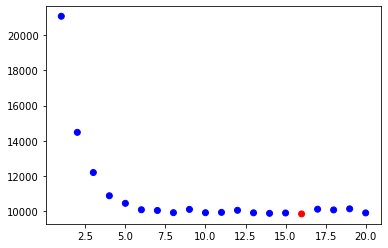

In [8]:
import matplotlib.pyplot as plt

min_mse = np.min(mse_values)
mask = np.array(mse_values) == min_mse
color = np.where(mask, 'red', 'blue')
plt.scatter(hyper_k, mse_values, color=color)
plt.show()

The lowest mse comes from k=16 at `9842`

## 4. Choosing between KFold and StratifiedKFold

StratifiedKFold takes group information into account to avoid building folds with imbalanced class distributions. To decide on which to use, I will need to find the `correlation` between the features and the target.

<AxesSubplot:>

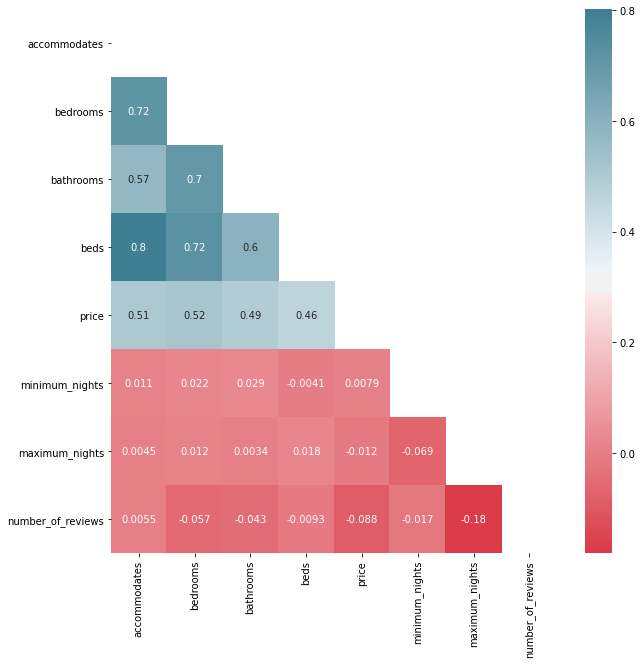

In [10]:
import seaborn as sns

corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
color = sns.diverging_palette(10, 220, as_cmap=True)
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(corr, mask=mask, cmap=color, annot=True)

It seems like 3 of the features have little to no correlations, and 4 have a decent linear relationship with the price. This suggest that, since none of the features really stands out, regular KFold would be fine. The one thing this heatmap shows is that later on I might benefit from creating derivative features out of the 4 good ones. 

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(5, shuffle=True, random_state=1)
knn = KNeighborsRegressor()
mses = cross_val_score(knn, X_train, y_train, cv=kf, n_jobs=-1,
                       scoring="neg_mean_squared_error")
rmses = np.sqrt(np.absolute(mses))
avg_rmse = np.mean(rmses)

print(rmses)
print(avg_rmse)

[123.68315332 149.79907326 123.91446904 105.92202967 115.22084049]
123.70791315749304
